https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#13viewthetopicsinldamodel

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word.

In [5]:
# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

**We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as [newsgroups.json](https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json).**

In [7]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


### Remove emails and newline characters

In [8]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


### Tokenization words and Clean-up
Converting each sentence into list of words

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


### Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

**Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.**

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


### Remove Stopwords, Make Bigrams and Lemmatize

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

**Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).**

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])
# id2word[0] # to check word by index

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

## Building the Topic Model

In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.012*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

### Model Perplexity and Coherence Score
A measure to judge how good a given topic model is.

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754129288466325

Coherence Score:  0.515758393754623


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      16.257961        1       1  0.336974 -0.001260
13     15.227504        1       2  0.291074 -0.003111
18     14.571011        1       3  0.328806 -0.128172
2       6.162408        1       4  0.091747  0.226463
15      5.973720        1       5  0.059663  0.222605
10      4.344136        1       6 -0.084986 -0.112877
17      4.177797        1       7  0.060982 -0.182977
12      3.586105        1       8 -0.022532 -0.036462
5       3.366075        1       9 -0.022890 -0.021238
16      3.271670        1      10 -0.029294  0.219730
6       3.227796        1      11 -0.062700 -0.017237
9       2.969311        1      12 -0.062878  0.139500
14      2.741298        1      13 -0.088855 -0.062629
3       2.731830        1      14 -0.047746 -0.117469
8       2.290860        1      15 -0.111490  0.003686
19      2.124102        1      16 -0.113665 -0.023370
11      2.081719        1      17 -0.092183 -0.110822
4       1.693802        1      18 -0.134212  0.001634
0       1.679172        1      19 -0.164197 -0.027992
1       1.521721        1      20 -0.131619  0.031999, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
11711  Default  57084.000000            ax  57084.000000  30.0000  30.0000
67468  Default  12491.000000          line  12491.000000  29.0000  29.0000
65392  Default  16294.000000           not  16294.000000  28.0000  28.0000
67775  Default  11141.000000  organization  11141.000000  27.0000  27.0000
21686  Default   3845.000000           max   3845.000000  26.0000  26.0000
17994  Default  10454.000000            do  10454.000000  25.0000  25.0000
59123  Default   9655.000000         write   9655.000000  24.0000  24.0000
67240  Default   7586.000000       article   7586.000000  23.0000  23.0000
32195  Default   8048.000000            be   8048.000000  22.0000  22.0000
30626  Default  11783.000000         would  11783.000000  21.0000  21.0000
68462  Default   6906.000000           say   6906.000000  20.0000  20.0000
10075  Default   5804.000000            go   5804.000000  19.0000  19.0000
1516   Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
31556  Default   4083.000000          host   4083.000000  17.0000  17.0000
53994  Default   6852.000000           get   6852.000000  16.0000  16.0000
57684  Default   5027.000000    university   5027.000000  15.0000  15.0000
72028  Default   1863.000000         space   1863.000000  14.0000  14.0000
4841   Default   2294.000000        window   2294.000000  13.0000  13.0000
21438  Default   3735.000000             s   3735.000000  12.0000  12.0000
37433  Default   7292.000000          know   7292.000000  11.0000  11.0000
64617  Default   3461.000000          year   3461.000000  10.0000  10.0000
54436  Default   4598.000000           use   4598.000000   9.0000   9.0000
8248   Default   1540.000000          game   1540.000000   8.0000   8.0000
10224  Default   1948.000000          mail   1948.000000   7.0000   7.0000
6491   Default   3006.000000         right   3006.000000   6.0000   6.0000
38760  Default   1684.000000     christian   1684.000000   5.0000   5.0000
40840  Default   1746.000000    government   1746.000000   4.0000   4.0000
39074  Default   1464.000000          team   1464.000000   3.0000   3.0000
60683  Default   3380.000000        system   3380.000000   2.0000   2.0000
42603  Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
2799   Topic20    119.371298          guru    120.323183   4.1774  -5.3259
9992   Topic20    117.623803  countersteer    118.575687   4.1773  -5.3406
58046  Topic20    113.026465       bradley    113.978349   4.1769  -5.3805
8958   Topic20    112.217104          lane    113.168988   4.1769  -5

## LDA Mallet Model (improvement over GenSim model)

In [25]:
# http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/nltk_data/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('gun', 0.0205374668052188),
   ('state', 0.01384078051033368),
   ('law', 0.013407805103336798),
   ('people', 0.012801639533541161),
   ('fire', 0.0076347996767116965),
   ('crime', 0.007375014432513567),
   ('kill', 0.007158526729015125),
   ('weapon', 0.007014201593349497),
   ('article', 0.006855443944117308),
   ('case', 0.006826578916984182)]),
 (14,
  [('key', 0.028493776473479535),
   ('system', 0.01069781562170211),
   ('line', 0.01036531594697353),
   ('encryption', 0.010278576901392162),
   ('file', 0.008702817573330635),
   ('security', 0.008153470284648634),
   ('bit', 0.008037818223873477),
   ('chip', 0.007806514102323161),
   ('entry', 0.00728607982883495),
   ('program', 0.006794558570540529)]),
 (0,
  [('space', 0.02426224147796943),
   ('launch', 0.007487942450747977),
   ('earth', 0.006850322897081664),
   ('year', 0.006539687729910897),
   ('nasa', 0.006310798659364015),
   ('system', 0.0060982588081419115),
   ('project', 0.005836671298945475),
   ('sate

### Finding the optimal number of topics for LDA

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
#%%time
import timeit
start_time = timeit.default_timer()

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

elapsed = timeit.default_timer() - start_time
print(elapsed)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15.7 µs


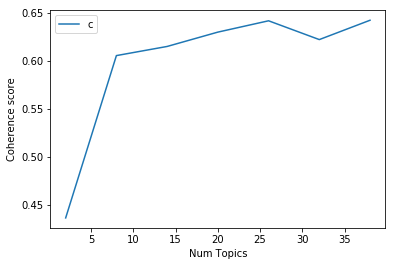

In [31]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4364
Num Topics = 8  has Coherence Value of 0.6056
Num Topics = 14  has Coherence Value of 0.6151
Num Topics = 20  has Coherence Value of 0.6301
Num Topics = 26  has Coherence Value of 0.6419
Num Topics = 32  has Coherence Value of 0.6223
Num Topics = 38  has Coherence Value of 0.6425


In [50]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"_" + 0.022*"organization" + 0.020*"line" + 0.017*"ca" + '
  '0.007*"newsreader_tin" + 0.006*"air" + 0.006*"cx" + 0.005*"cd" + 0.004*"ad" '
  '+ 0.004*"md"'),
 (1,
  '0.023*"drive" + 0.017*"card" + 0.016*"problem" + 0.015*"system" + '
  '0.012*"scsi" + 0.012*"driver" + 0.011*"mac" + 0.011*"window" + 0.010*"work" '
  '+ 0.009*"bit"'),
 (2,
  '0.009*"drug" + 0.008*"study" + 0.007*"line" + 0.007*"food" + '
  '0.007*"organization" + 0.006*"article" + 0.006*"problem" + 0.006*"research" '
  '+ 0.006*"year" + 0.006*"doctor"'),
 (3,
  '0.015*"question" + 0.013*"point" + 0.012*"exist" + 0.011*"claim" + '
  '0.010*"reason" + 0.010*"true" + 0.009*"thing" + 0.009*"make" + '
  '0.009*"argument" + 0.009*"write"'),
 (4,
  '0.026*"game" + 0.019*"team" + 0.016*"year" + 0.015*"play" + 0.013*"player" '
  '+ 0.012*"win" + 0.008*"season" + 0.008*"good" + 0.007*"hockey" + '
  '0.007*"fan"'),
 (5,
  '0.011*"make" + 0.011*"work" + 0.010*"year" + 0.010*"money" + '
  '0.010*"president" + 0.010*"pe

### Finding the dominant topic in each sentence

In [51]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2170,"car, gun, buy, good, firearm, drive, weapon, a...",From: (wheres my thing) Subject: WHAT car is t...
1,1,1.0,0.2010,"drive, card, problem, system, scsi, driver, ma...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,14.0,0.2007,"bike, line, power, work, organization, ground,...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,12.0,0.3602,"window, file, program, image, display, version...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,1.0,0.2332,"drive, card, problem, system, scsi, driver, ma...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,8.0,0.4152,"car, gun, buy, good, firearm, drive, weapon, a...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,13.0,0.1548,"write, article, line, organization, nntp_post,...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,10.0,0.1733,"post, information, mail, send, list, file, inc...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,9.0,0.1875,"people, law, state, write, case, article, make...",Subject: Re: Dont more innocents die without t...
9,9,3.0,0.3928,"question, point, exist, claim, reason, true, t...",From: (Jon Livesey) Subject: Re: Genocide is C...


### Topic distribution across documents

In [56]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,8.0,"car, gun, buy, good, firearm, drive, weapon, a...",135.0,0.0119
1,1.0,"drive, card, problem, system, scsi, driver, ma...",1414.0,0.1250
2,14.0,"bike, line, power, work, organization, ground,...",546.0,0.0483
3,12.0,"window, file, program, image, display, version...",462.0,0.0408
4,1.0,"drive, card, problem, system, scsi, driver, ma...",1057.0,0.0934
